# TPG Examples
This document shows how to use the PyTPG API. We make use of OpenAI Gym to run examples, and we assume you already have PyTPG installed, see the readme for installation instructions for PyTPG.

## General Setup

In [1]:
from __future__ import division
from IPython.display import clear_output
import numpy as np
import gym
import matplotlib.pyplot as plt
from IPython import display

# how to render in Jupyter: 
# https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
# https://www.youtube.com/watch?v=O84KgRt6AJI
def show_state(env, step=0, name='', info=''):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (name, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
# To transform pixel matrix to a single vector.
def getState(inState):
    # each row is all 1 color
    rgbRows = np.reshape(inState,(len(inState[0])*len(inState), 3)).T

    # add each with appropriate shifting
    # get RRRRRRRR GGGGGGGG BBBBBBBB
    return np.add(np.left_shift(rgbRows[0], 16),
        np.add(np.left_shift(rgbRows[1], 8), rgbRows[2]))

In [2]:
env = gym.make('Assault-v0') # make the environment

In [3]:
print(env.action_space) # learn size of action space

Discrete(7)


In [4]:
# import to do training
from tpg.tpg_trainer import TpgTrainer
# import to run an agent (always needed)
from tpg.tpg_agent import TpgAgent

## Example: Basic Generational Selection (with graphics)

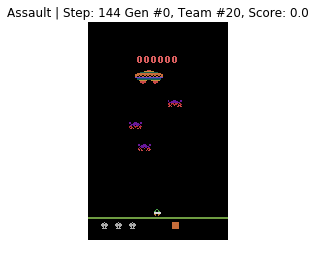

KeyboardInterrupt: 

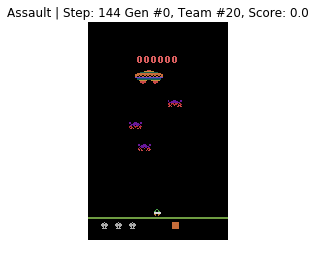

In [5]:
%matplotlib inline
import time # for tracking time

tStart = time.time()

# first create an instance of the TpgTrainer
# this creates the whole population and everything
trainer = TpgTrainer(actions=range(7), teamPopSize=20)

curScores = [] # hold scores in a generation
summaryScores = [] # record score summaries for each gen (min, max, avg)

# 3 generations isn't much (not even close), but some improvements
# should be seen.
for gen in range(3): # generation loop
    curScores = [] # new list per gen
    
    while True: # loop to go through agents
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break # no more agents, so proceed to next gen
        
        # check if agent already has score
        if agent.taskDone():
            score = agent.getOutcome()
        else:
            state = env.reset() # get initial state and prep environment
            score = 0
            for i in range(200): # run episodes that last 200 frames
                show_state(env, i, 'Assault', 'Gen #' + str(gen) + 
                           ', Team #' + str(teamNum) +
                           ', Score: ' + str(score)) # render env

                # must transform to at-least int-32 (for my getState to bitshift correctly)
                act = agent.act(getState(np.array(state, dtype=np.int32))) # get action from agent

                # feedback from env
                state, reward, isDone, debug = env.step(act)
                score += reward # accumulate reward in score
                if isDone:
                    break # end early if losing state

            agent.reward(score) # must reward agent (if didn't already score)
            
        curScores.append(score) # store score
            
    # at end of generation, make summary of scores
    summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    trainer.evolve()
    
#clear_output(wait=True)
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results:\nMin, Max, Avg')
for result in summaryScores:
    print(result[0],result[1],result[2])

## Example: Generational Selection with Multiprocessing (no graphics)

This example is just to show a different way to run the API, a far superior way. It uses a different method to get the agents, doesn't use graphics (but can), and uses multiprocessing.

In [5]:
"""
Run each agent in this method for parallization.
Args:
    args: (TpgAgent, envName, scoreList, numEpisodes, numFrames)
"""
def runAgent(args):
    agent = args[0]
    envName = args[1]
    scoreList = args[2]
    numEpisodes = args[3] # number of times to repeat game
    numFrames = args[4] 
    
    # skip if task already done by agent
    if agent.taskDone(envName+'-'+str(numFrames)):
        print('Agent #' + str(agent.getAgentNum()) + ' can skip.')
        scoreList.append((agent.getUid(), agent.getOutcomes()))
        return
    
    env = gym.make(envName)
    valActs = range(env.action_space.n) # valid actions, some envs are less
    
    scoreTotal = 0 # score accumulates over all episodes
    for ep in range(numEpisodes): # episode loop
        state = env.reset()
        scoreEp = 0
        numRandFrames = 0
        if numEpisodes > 1:
            numRandFrames = random.randint(0,30)
        for i in range(numFrames): # frame loop
            if i < numRandFrames:
                _, _, isDone, _ = env.step(env.action_space.sample())
                if isDone: # don't count it if lose on random steps
                    ep -= 1
                continue

            act = agent.act(getState(state), valActs=valActs)

            # feedback from env
            state, reward, isDone, debug = env.step(act)
            scoreEp += reward # accumulate reward in score
            if isDone:
                break # end early if losing state
                
        print('Agent #' + str(agent.getAgentNum()) + 
              ' | Ep #' + str(ep) + ' | Score: ' + str(scoreEp))
        scoreTotal += scoreEp
       
    scoreTotal /= numEpisodes
    env.close()
    agent.reward(scoreTotal, envName+'-'+str(numFrames))
    scoreList.append((agent.getUid(), agent.getOutcomes()))

In [6]:
import multiprocessing as mp
import time

tStart = time.time()

trainer = TpgTrainer(actions=range(7), teamPopSize=360)

processes = 7 
man = mp.Manager()
pool = mp.Pool(processes=processes, maxtasksperchild=1)
    
allScores = [] # track all scores each generation

for gen in range(30): # do 30 generations of training
    scoreList = man.list()
    
    # get agents, noRef to not hold reference to trainer in each one
    # don't need reference to trainer in multiprocessing
    agents = trainer.getAllAgents(skipTasks = ['Boxing-v0-18000'],
                                  noRef=True) # swap out agents only at start of generation

    # run the agents
    pool.map(runAgent, 
        [(agent, 'Boxing-v0', scoreList, 1, 18000)
        for agent in agents])
    
    # apply scores, must do this when multiprocessing
    # because agents can't refer to trainer
    teams = trainer.applyScores(scoreList)
    # important to remember to set tasks right, unless not using task names
    # task name set in runAgent()
    trainer.evolve(tasks=['Boxing-v0-18000']) # go into next gen
    
    # an easier way to track stats than the above example
    scoreStats = trainer.scoreStats
    allScores.append((scoreStats['min'], scoreStats['max'], scoreStats['average']))
    
    clear_output(wait=True)
    print('Time Taken (Seconds): ' + str(time.time() - tStart))
    print('Results so far: ' + str(allScores))
    
clear_output(wait=True)
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results:\nMin, Max, Avg')
for score in allScores:
    print(score[0],score[1],score[2])

Time Taken (Seconds): 309.9768624305725
Results so far: [(-100.0, 4.0, -57.977777777777774)]
Agent #308 | Ep #0 | Score: -41.0
Agent #274 | Ep #0 | Score: -100.0
Agent #319 | Ep #0 | Score: -41.0
Agent #298 | Ep #0 | Score: -38.0
Agent #257 | Ep #0 | Score: -36.0
Agent #240 | Ep #0 | Score: -41.0
Agent #286 | Ep #0 | Score: -41.0
Agent #307 | Ep #0 | Score: -89.0
Agent #295 | Ep #0 | Score: -100.0
Agent #273 | Ep #0 | Score: -36.0
Agent #318 | Ep #0 | Score: -34.0
Agent #256 | Ep #0 | Score: -30.0
Agent #284 | Ep #0 | Score: -41.0
Agent #238 | Ep #0 | Score: -41.0
Agent #306 | Ep #0 | Score: -30.0
Agent #271 | Ep #0 | Score: -41.0
Agent #293 | Ep #0 | Score: -54.0
Agent #255 | Ep #0 | Score: -30.0
Agent #316 | Ep #0 | Score: -36.0
Agent #283 | Ep #0 | Score: -54.0
Agent #236 | Ep #0 | Score: -54.0
Agent #305 | Ep #0 | Score: -100.0
Agent #292 | Ep #0 | Score: -41.0
Agent #269 | Ep #0 | Score: -41.0
Agent #254 | Ep #0 | Score: -38.0
Agent #313 | Ep #0 | Score: -22.0
Agent #235 | Ep #0 |

Process ForkPoolWorker-35:
Process ForkPoolWorker-33:
Process ForkPoolWorker-36:
Process ForkPoolWorker-30:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-32:
  File "/home/amaral/anaconda2/envs/oaigym/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/amaral/anaconda2/envs/oaigym/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/amaral/anaconda2/envs/oaigym/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/amaral/anaconda2/envs/oaigym/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/amaral/anaconda2/envs/oaigym/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-5-4e0845a9490a>", line 36, in runAgent
    act = agent.act(getSt

KeyboardInterrupt: 

For the results above, boxing is a particularly difficult game that takes a while for improvement. The max score will sometimes take a dip because the root team that had the max score may become a child of another root team during a mutation, making it no longer a root team. But this new mutation either shortly disapears if it is no good and the old root team is restored, or, it will perform well and stay for a while.

## Tournament Selection (In progress)

In [4]:
import multiprocessing as mp
import time

tStart = time.time()

lock = mp.Lock()

trainer = TpgTrainer(actions=range(7), teamPopSizeInit=360)

processes = 4 # how many to run concurrently (4 is best for my local desktop)

m = mp.Manager()
envQueue = m.Queue()
# each process needs its own environment
for i in range(processes):
    envQueue.put(gym.make('Assault-v0'))

pool = mp.Pool(processes=processes)
    
summaryScores = [] # record score summaries for population
    
# tournament loop 
# 450 tournaments of size 8 approximately equals 10 generations
# *at pop size 360
for tourn in range(450): 
    scoreQueue = m.Queue() # hold agents when finish, to actually apply score

    # run tournament
    # skipTasks=[] so we get all agents, even if already scored,
    # just to report the obtained score for all agents.
    pool.map(runAgent, 
                 [(agent, envQueue, scoreQueue) 
                  for agent in trainer.getTournamentAgents()])
    
    scores = [] # convert scores into list
    while not scoreQueue.empty():
        scores.append(scoreQueue.get())
    
    # apply scores
    teams = trainer.applyScores(scores) # get teams from trainer
    trainer.evolve(tourneyTeams=teams,tasks=[]) # evolve tournament players
    
    # report score once equivalent to a generation
    if (tourn+1) % 45 == 0:
        scoreStats = trainer.generateScoreStats()

        # at end of generation, make summary of scores
        summaryScores.append((scoreStats['min'], 
                        scoreStats['max'],
                        scoreStats['average'])) # min, max, avg

        clear_output(wait=True)
        print('Time Taken (Seconds): ' + str(time.time() - tStart))
        print('Results so far: ' + str(summaryScores))
    
clear_output(wait=True)
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results: ' + str(summaryScores))

Time Taken (Seconds): 45202.94136309624
Results: [(0, 16905.0, 50.91867469879518), (0, 31521.0, 99.43533123028391), (0, 47733.0, 157.01644736842104), (0, 59262.0, 196.2317880794702), (0, 63903.0, 215.16161616161617), (0, 66339.0, 230.34375), (0, 68754.0, 242.09154929577466), (0, 68460.0, 244.5), (0, 73290.0, 251.8556701030928), (0, 70371.0, 256.8284671532847)]
